# Data Cleaning

In this notebook the data is cleaned and Features are introduced. The cleaning is refined if an issue is discovered in EDA. 

# Config Notebook

In [1658]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats 
import pingouin as pg

from sklearn.preprocessing import MinMaxScaler

# import pyarrow as pa

In [1659]:
# config packages
pd.options.mode.copy_on_write = "warn"

In [1660]:
# load project config
with open("../config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
config

{'data_path_wine_red': 'data/wine+quality/winequality-red.csv',
 'data_path_wine_white': 'data/wine+quality/winequality-white.csv'}

In [1661]:
# useful constants
# NOTE - it might be better to build a util file and import that one 
%run ../src/constants.py

# Import

In [1662]:
# TODO - how to build paths in python 
# wine_r = pd.read_csv('data//wine+quality//winequality-red.csv', sep=';', dtype_backend=) # pyarrow enhanced data frame
wine_r = pd.read_csv('../' + config['data_path_wine_red'], sep=';')
wine_w = pd.read_csv('../' + config['data_path_wine_white'], sep=';')

# Set Data Types

In [1663]:
wine_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [1664]:
wine_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


# Boundaries: Legal Limits

In [1665]:
# build data frame that holds all legal limits
# TODO fix performance warning
quantities = ['volatile_acidity', 'total_sulfur_dioxide']
countries = ['US', 'EU', 'AUS']

legal_limits = pd.DataFrame(index=pd.MultiIndex.from_product([quantities, wine_color.categories, countries]), columns=['limit', 'limit_type'])

# U.S, the legal limits of Volatile Acidity
legal_limits.loc[('volatile_acidity', 'white', 'US'),:] = [1.1, 'upper']
legal_limits.loc[('volatile_acidity', 'red', 'US'),:] = [1.2, 'upper']

# in the EU, red wines can only have 160mg/L, 
# while white and rose wines can have about 210mg/L. 
# Sweet wines are allowed to have 400mg/L. 
# Legal limits are set at 350mg/L for the USA, 
# and 250mg/L for Australia.
legal_limits.loc[('total_sulfur_dioxide', 'white', 'EU'),:] = [210, 'upper']
legal_limits.loc[('total_sulfur_dioxide', 'red', 'EU'),:]   = [160, 'upper']
legal_limits.loc[('total_sulfur_dioxide', 'white', 'US'),:] = [350, 'upper']
legal_limits.loc[('total_sulfur_dioxide', 'red', 'US'),:]   = [350, 'upper']
legal_limits.loc[('total_sulfur_dioxide', 'white', 'AUS'),:] = [250, 'upper']
legal_limits.loc[('total_sulfur_dioxide', 'red', 'AUS'),:]  = [250, 'upper']

legal_limits


C:\Users\olive\AppData\Local\Temp\ipykernel_46888\1182282770.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  legal_limits.loc[('volatile_acidity', 'white', 'US'),:] = [1.1, 'upper']
C:\Users\olive\AppData\Local\Temp\ipykernel_46888\1182282770.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  legal_limits.loc[('volatile_acidity', 'red', 'US'),:] = [1.2, 'upper']
C:\Users\olive\AppData\Local\Temp\ipykernel_46888\1182282770.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  legal_limits.loc[('total_sulfur_dioxide', 'white', 'EU'),:] = [210, 'upper']
C:\Users\olive\AppData\Local\Temp\ipykernel_46888\1182282770.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  legal_limits.loc[('total_sulfur_dioxide', 'red', 'EU'),:]   = [160, 'upper']
C:\Users\olive\AppData\Local\Temp\ipykernel_46888\1182282770.py:19: PerformanceWarning: indexing past lexsort depth may impact performa

limit limit_type
volatile_acidity     red   US    1.2      upper
                           EU    NaN        NaN
                           AUS   NaN        NaN
                     white US    1.1      upper
                           EU    NaN        NaN
                           AUS   NaN        NaN
total_sulfur_dioxide red   US    350      upper
                           EU    160      upper
                           AUS   250      upper
                     white US    350      upper
                           EU    210      upper
                           AUS   250      upper

# Standardize: rename and reorder columns
I suspect similarities within the grouped quantities, so I want to see them side by side.

In [1666]:
# set column titles
wine_r = wine_r.rename(columns=lambda x: x.replace(' ','_').lower())
wine_w = wine_w.rename(columns=lambda x: x.replace(' ','_').lower())

In [1667]:
# reorder columns
wine_r = wine_r[all_columns]
wine_w = wine_w[all_columns]

In [1668]:
# set units if necessary!

# Keep original data

In [1669]:
wine_w_orig = wine_w.copy()
wine_r_orig = wine_r.copy()
wine_orig   = pd.concat([wine_w_orig, wine_r_orig], axis=0)

In [1670]:
wine_orig

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
0,3.00,7.0,0.270,0.36,0.045,170.0,45.0,0.45,20.7,1.00100,8.8,6
1,3.30,6.3,0.300,0.34,0.049,132.0,14.0,0.49,1.6,0.99400,9.5,6
2,3.26,8.1,0.280,0.40,0.050,97.0,30.0,0.44,6.9,0.99510,10.1,6
3,3.19,7.2,0.230,0.32,0.058,186.0,47.0,0.40,8.5,0.99560,9.9,6
4,3.19,7.2,0.230,0.32,0.058,186.0,47.0,0.40,8.5,0.99560,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,3.45,6.2,0.600,0.08,0.090,44.0,32.0,0.58,2.0,0.99490,10.5,5
1595,3.52,5.9,0.550,0.10,0.062,51.0,39.0,0.76,2.2,0.99512,11.2,6
1596,3.42,6.3,0.510,0.13,0.076,40.0,29.0,0.75,2.3,0.99574,11.0,6
1597,3.57,5.9,0.645,0.12,0.075,44.0,32.0,0.71,2.0,0.99547,10.2,5


# Data Cleaning: NaN and duplicates

## NaN values
There are no NaN values

In [1671]:
wine_r.isna().sum()

ph                      0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
chlorides               0
total_sulfur_dioxide    0
free_sulfur_dioxide     0
sulphates               0
residual_sugar          0
density                 0
alcohol                 0
quality                 0
dtype: int64

In [1672]:
wine_w.isna().sum()

ph                      0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
chlorides               0
total_sulfur_dioxide    0
free_sulfur_dioxide     0
sulphates               0
residual_sugar          0
density                 0
alcohol                 0
quality                 0
dtype: int64

## Drop Duplicates

Duplicates are present, however, they do not need to be removed, because some wines just have the same set of values. They are distinguished by the index.

Why is the fraction of duplicates so high? 
- The high fraction of duplicates indicate that the attribute set is not really enough to distinguish between wines.
- Measurement accuracy might be too low.

In [1673]:
dups_r = wine_r.duplicated(all_inputs)#, keep=False)
dups_w = wine_w.duplicated(all_inputs)#, keep=False)

# print('Overall duplicates', dups.sum(), dups.sum() / wine.shape[0])
print('White wine duplicates', dups_w.sum(), dups_w.sum() / wine_w.shape[0])
print('Red wine duplicates', dups_r.sum(), dups_r.sum() / wine_r.shape[0])

White wine duplicates 937 0.19130257247856267
Red wine duplicates 240 0.150093808630394


In [1674]:
wine_r[wine_r.duplicated(keep=False)].sort_values(['fixed_acidity', 'volatile_acidity'])

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
142,3.68,5.2,0.340,0.00,0.050,63.0,27.0,0.79,1.8,0.99160,14.0,6
144,3.68,5.2,0.340,0.00,0.050,63.0,27.0,0.79,1.8,0.99160,14.0,6
131,3.63,5.6,0.500,0.09,0.049,99.0,17.0,0.63,2.3,0.99370,13.0,5
132,3.63,5.6,0.500,0.09,0.049,99.0,17.0,0.63,2.3,0.99370,13.0,5
1488,3.72,5.6,0.540,0.04,0.049,13.0,5.0,0.58,1.7,0.99420,11.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
391,3.06,13.7,0.415,0.68,0.085,43.0,17.0,0.80,2.9,1.00140,10.0,6
243,3.07,15.0,0.210,0.44,0.075,24.0,10.0,0.84,2.2,1.00005,9.2,7
244,3.07,15.0,0.210,0.44,0.075,24.0,10.0,0.84,2.2,1.00005,9.2,7
554,2.92,15.5,0.645,0.49,0.095,23.0,10.0,0.74,4.2,1.00315,11.1,5


In [1675]:
# remove duplicates
wine_w = wine_w.drop_duplicates(all_inputs)
wine_r = wine_r.drop_duplicates(all_inputs)

# Check Legal Limits

Check if legal limits are surpassed and only keep legal wines.

In [1676]:
wine_w.head()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
0,3.00,7.0,0.27,0.36,0.045,170.0,45.0,0.45,20.7,1.0010,8.8,6
1,3.30,6.3,0.30,0.34,0.049,132.0,14.0,0.49,1.6,0.9940,9.5,6
2,3.26,8.1,0.28,0.40,0.050,97.0,30.0,0.44,6.9,0.9951,10.1,6
3,3.19,7.2,0.23,0.32,0.058,186.0,47.0,0.40,8.5,0.9956,9.9,6
6,3.18,6.2,0.32,0.16,0.045,136.0,30.0,0.47,7.0,0.9949,9.6,6


In [1677]:
# illegal white wines
wine_w_above_limit_sulfur_dioxide   = wine_w.total_sulfur_dioxide > legal_limits.loc[('total_sulfur_dioxide','white','EU')].limit
wine_w_above_limit_vol_acid         = wine_w.volatile_acidity > legal_limits.loc[('volatile_acidity','white','US')].limit
wine_w_illegal                      = wine_w_above_limit_sulfur_dioxide | wine_w_above_limit_vol_acid

wine_w_illegal_counts = wine_w[wine_w_illegal].quality.value_counts().sort_index()
wine_w_illegal_counts

quality
3      5
4      6
5     96
6    102
7      5
8      1
Name: count, dtype: int64

In [1678]:
print(wine_w_above_limit_sulfur_dioxide.sum())
print(wine_w_above_limit_vol_acid.sum())

215
0


Text(0, 0.5, '')

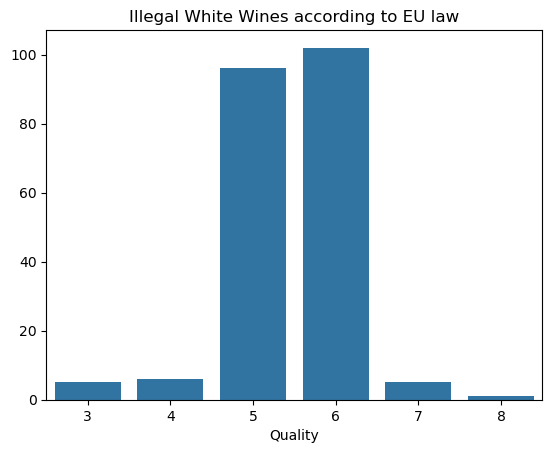

In [1679]:
ax = sns.barplot(wine_w_illegal_counts)

ax.set_title('Illegal White Wines according to EU law')
ax.set_xlabel('Quality')
ax.set_ylabel('')

In [1680]:
# illegal red wines
wine_r_above_limit_sulfur_dioxide   = wine_r.total_sulfur_dioxide > legal_limits.loc[('total_sulfur_dioxide','red','EU')].limit
wine_r_above_limit_vol_acid         = wine_r.volatile_acidity > legal_limits.loc[('volatile_acidity','red','US')].limit
wine_r_illegal                      = wine_r_above_limit_sulfur_dioxide | wine_r_above_limit_vol_acid

wine_r[wine_r_illegal].quality.value_counts().sort_index()

quality
3    1
5    3
6    1
7    2
Name: count, dtype: int64

In [1681]:
wine_w[wine_w_illegal & (wine_w.quality > 6)]

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
432,3.18,7.4,0.155,0.34,0.045,214.0,73.5,0.61,2.3,0.99340,9.9,7
1609,3.09,8.1,0.200,0.49,0.048,212.0,46.0,0.46,11.8,0.99680,10.0,7
1980,3.14,7.6,0.200,0.30,0.056,212.5,53.0,0.46,14.2,0.99900,8.9,8
2167,3.14,7.4,0.190,0.30,0.053,229.0,48.5,0.49,12.8,0.99860,9.1,7
2175,3.14,7.4,0.190,0.30,0.053,212.0,48.5,0.49,12.8,0.99860,9.1,7
2770,3.26,6.4,0.440,0.44,0.048,228.0,29.0,0.54,14.4,0.99955,8.8,7


# Value Consistency Checks

In [1682]:
(wine_w.citric_acid > wine_w.fixed_acidity).sum()

np.int64(0)

# Normalize values in data set

Normalize values in order to visualize physiochemical wine profiles.

Requirements:
1. Drop outliers
2. Normalize (When should data be normalized? Reduce effect of large numbers?)

In [1683]:
# white wine
# TODO create one scale for acids
scaler = MinMaxScaler(feature_range=(0, 1)).fit_transform(wine_w[all_inputs])
wine_w_norm = pd.DataFrame(scaler, index=wine_w.index, columns=all_inputs)
wine_w_norm.describe()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,0.432235,0.292245,0.196606,0.201405,0.109511,0.297433,0.114596,0.314362,0.081516,0.128774,0.417638
std,0.137769,0.083352,0.101409,0.073763,0.068554,0.100067,0.059965,0.132003,0.074565,0.055998,0.196303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.336364,0.240385,0.127451,0.162651,0.077151,0.225058,0.073171,0.220930,0.015337,0.086948,0.241935
50%,0.418182,0.288462,0.176471,0.192771,0.097923,0.287703,0.108014,0.302326,0.062883,0.123193,0.387097
75%,0.518182,0.336538,0.245098,0.234940,0.121662,0.364269,0.149826,0.383721,0.127301,0.165799,0.548387
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1684]:
# red wine
scaler = MinMaxScaler(feature_range=(0, 1)).fit_transform(wine_r[all_inputs])
wine_r_norm = pd.DataFrame(scaler, index=wine_r.index, columns=all_inputs)
wine_r_norm.describe()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,0.448651,0.328371,0.280464,0.272333,0.127085,0.144261,0.209765,0.196829,0.111192,0.487441,0.312664
std,0.122076,0.153716,0.125364,0.195537,0.082432,0.118053,0.147145,0.102196,0.092624,0.137219,0.166472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370079,0.221239,0.184932,0.090000,0.096828,0.056537,0.084507,0.131737,0.068493,0.406021,0.169231
50%,0.448819,0.292035,0.273973,0.260000,0.111853,0.113074,0.183099,0.173653,0.089041,0.486784,0.276923
75%,0.519685,0.407080,0.356164,0.430000,0.131886,0.201413,0.281690,0.239521,0.116438,0.569016,0.415385
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1685]:
# TODO move this temporary check
wine_w_norm['quality'] = wine_w.quality
wine_w_norm.corr(numeric_only=True)

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
ph,1.000000,-0.431274,-0.046954,-0.183015,-0.090573,0.008239,-0.007750,0.142353,-0.165997,-0.063734,0.093095,0.123829
fixed_acidity,-0.431274,1.000000,-0.019214,0.298959,0.024036,0.082425,-0.058396,-0.017453,0.083620,0.266091,-0.110788,-0.124636
volatile_acidity,-0.046954,-0.019214,1.000000,-0.163228,0.086287,0.102315,-0.102471,-0.021150,0.098340,0.060603,0.046815,-0.190678
citric_acid,-0.183015,0.298959,-0.163228,1.000000,0.132590,0.122845,0.091681,0.049442,0.106269,0.160076,-0.076514,0.007065
chlorides,-0.090573,0.024036,0.086287,0.132590,1.000000,0.191145,0.101272,0.017871,0.076091,0.253088,-0.356928,-0.217739
total_sulfur_dioxide,0.008239,0.082425,0.102315,0.122845,0.191145,1.000000,0.619437,0.136544,0.409583,0.536868,-0.446643,-0.183356
free_sulfur_dioxide,-0.007750,-0.058396,-0.102471,0.091681,0.101272,0.619437,1.000000,0.037932,0.306835,0.294638,-0.251768,0.010507
sulphates,0.142353,-0.017453,-0.021150,0.049442,0.017871,0.136544,0.037932,1.000000,-0.020503,0.082048,-0.022850,0.053200
residual_sugar,-0.165997,0.083620,0.098340,0.106269,0.076091,0.409583,0.306835,-0.020503,1.000000,0.820498,-0.398167,-0.117339
density,-0.063734,0.266091,0.060603,0.160076,0.253088,0.536868,0.294638,0.082048,0.820498,1.000000,-0.760162,-0.337805


# Standardize values in data set?

1. Drop outliers
2. Standardize (z-score)

Why?
- compare physio chemical profile of wines
- "Data standardization comes into the picture when features of the input data set have large differences between their ranges, or simply when they are measured in different units (e.g., pounds, meters, miles, etc.). These differences in the ranges of initial features cause trouble for many machine learning models. For example, for the models that are based on distance computation, if one of the features has a broad range of values, the distance will be governed by this particular feature."

In [1686]:
# TODO extend for all numerical columns
def standardize_z_score(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Normalize all continuous values to [0, 1] 
    '''
    return (df-df.mean())/df.std()


In [1687]:
# white wine
wine_w_zscore = wine_w.copy()
wine_w_zscore[all_inputs] = standardize_z_score(wine_w[all_inputs])
wine_w_zscore.describe()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality
count,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3.961000e+03,3961.000000
mean,1.305921e-15,-7.462403e-16,1.605493e-16,-4.305232e-17,-5.309787e-16,2.296124e-16,1.040431e-16,-5.040710e-16,1.677247e-16,1.251388e-14,-1.722093e-16,5.854835
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.890683
min,-3.137394e+00,-3.506157e+00,-1.938741e+00,-2.730444e+00,-1.597435e+00,-2.972323e+00,-1.911048e+00,-2.381468e+00,-1.093214e+00,-2.299642e+00,-2.127523e+00,3.000000
25%,-6.958845e-01,-6.221838e-01,-6.819386e-01,-5.253923e-01,-4.720257e-01,-7.232596e-01,-6.908283e-01,-7.077954e-01,-8.875223e-01,-7.469302e-01,-8.950613e-01,5.000000
50%,-1.020038e-01,-4.538926e-02,-1.985530e-01,-1.170494e-01,-1.690310e-01,-9.723169e-02,-1.097715e-01,-9.117923e-02,-2.498782e-01,-9.968011e-02,-1.555843e-01,6.000000
75%,6.238505e-01,5.314053e-01,4.781869e-01,4.546308e-01,1.772487e-01,6.679136e-01,5.874967e-01,5.254370e-01,6.140267e-01,6.611831e-01,6.660569e-01,6.000000
max,4.121148e+00,8.491171e+00,7.922325e+00,1.082654e+01,1.298960e+01,7.020938e+00,1.476528e+01,5.194102e+00,1.231788e+01,1.555826e+01,2.966652e+00,9.000000


In [1688]:
# red wine
wine_r_zscore = wine_r.copy()
wine_r_zscore[all_inputs] = standardize_z_score(wine_r[all_inputs])

# Features
 
 The following features are introduced:
- Quality Categories
- Free sulfur dioxide / Total sulfur dioxide -> aging? exposure to oxidation and spoilage

## Wine Type: Color

In [1689]:
# setting color as categorical data
wine_color = pd.CategoricalDtype(
    ["red", "white"], ordered=False
)
# wine_r['color'] = wine_color.categories[0] # NOTE this will only set the string, ot the category
# wine_w['color'] = wine_color.categories[1]
wine_r['color'] = 'red'
wine_w['color'] = 'white'
wine_r.color = wine_r.color.astype(wine_color)
wine_w.color = wine_w.color.astype(wine_color)

## Quality Categories

Can there be a common quality label for red and white?
- The chemical compositions as measured are very different. 
- The quality label is a good reduction / condensation / abstraction of the complex quality rating by the experts (non-linear, multiple and varying "measurement devices" per wine, averaging). What's the difference between 7 and 8 anyways? 

In [1690]:
def map_quality_label(quality_rating):
    pass
map_quality_label = lambda value: 'low' if value <= 5 else 'medium' if value < 7 else 'high'
    # lambda value: 'low' if value <= 5 else 'medium' if value <= 7 else 'high'

In [1691]:
# red
wine_r['quality_label'] = wine_r['quality'].apply(map_quality_label)

# transform into categorical type
wine_r['quality_label'] = pd.Categorical(wine_r['quality_label'], categories=['low', 'medium', 'high'])

wine_r_norm['quality_label'] = wine_r['quality_label']

In [1692]:
# white
wine_w['quality_label'] = wine_w['quality'].apply(map_quality_label)

# transform into categorical type
wine_w['quality_label'] = pd.Categorical(wine_w['quality_label'], categories=['low', 'medium', 'high'])

wine_w_norm['quality_label'] = wine_w['quality_label']

## Legal Limit Tag

In [1693]:
# white wine
wine_w['total_sulfur_dioxide_above_eu_limit'] = wine_w_above_limit_sulfur_dioxide
wine_w['volatile_acid_above_eu_limit'] = wine_w_above_limit_vol_acid

In [1694]:
# red wine
wine_r['total_sulfur_dioxide_above_eu_limit'] = wine_r_above_limit_sulfur_dioxide
wine_r['volatile_acid_above_eu_limit'] = wine_r_above_limit_vol_acid

## Outlier Count
Analyse the outliers: count, distribution

With IQR method

In [1695]:
# outliers 
def find_outliers(df: pd.DataFrame, gby=[]) -> pd.DataFrame:
    '''
    Find outliers in dataframe with numerical values.

    Returns
    --------
    DataFrame with True/False if outlier or not
    '''
    # TODO does not work for all data frames
    if type(df)==pd.DataFrame:
        df = df.select_dtypes(include='number').columns

    q25 = df.quantile(.25)
    q75 = df.quantile(.75)
    iqr = q75 - q25
    lower_boundary = q25 - 1.5*iqr
    upper_boundary = q75 + 1.5*iqr
    return ((df<lower_boundary) | (df>upper_boundary))


In [1696]:
def apply_outliers_thresh(df: pd.DataFrame, is_outlier: pd.Series, thresh: float, sort_by='', ascending=False):
    '''
    Only keep thresh amount of outliers, remove sorted by given column in given order; if multiple values remain, stop removal.
    '''
    # get outliers
    outliers = df[is_outlier]
    # sort
    outliers = outliers.sort_values(by=sort_by, ascending=ascending)
    # count outliers to be removed
    n = int(np.ceil(sum(is_outlier)*(1-thresh)))
    # reset is_outlier
    is_outlier_ = is_outlier.copy()
    is_outlier_[outliers.index[n:]] = False
    return is_outlier_

In [ ]:
# white wine outliers
# TODO find outliers by quality_label
groupby_columns = ['quality_label']
wine_w_is_outlier = wine_w[all_inputs].apply(lambda x: find_outliers(x, groupby_columns))

# exclude quantities
wine_w_is_outlier.chlorides = False
wine_w_is_outlier.residual_sugar = False
wine_w_is_outlier.density = False
wine_w_is_outlier.ph = False

# keep below a certain threshold and remove the low quality ratings first
OUTLIER_THRESH = 0.05
wine_w_is_outlier_any = wine_w_is_outlier.T.any().T
sort_by = 'quality'
wine_w_is_outlier_any_ = apply_outliers_thresh(wine_w, wine_w_is_outlier_any, OUTLIER_THRESH, sort_by, True) # problem: dimensions don't match? 

# reset is_outlier matrix
# TODO this look like shit, refactor!
ids = ~wine_w_is_outlier_any_ & (wine_w_is_outlier_cnt>0)
wine_w_is_outlier.loc[ids] = False

# count outliers per wine
wine_w_is_outlier_cnt = wine_w_is_outlier.T.sum().T

In [1597]:
# check: see which wines were included now!
wine_w[~wine_w_is_outlier_any_ & (wine_w_is_outlier_cnt>0)]

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,color,quality_label,total_sulfur_dioxide_above_eu_limit,volatile_acid_above_eu_limit


In [1601]:
# red wine outliers
groupby_columns = ['quality_label']
wine_r_is_outlier = wine_r[all_inputs].apply(lambda x: find_outliers(x, groupby_columns))
wine_r_is_outlier_any = wine_r_is_outlier.T.any().T
wine_r_is_outlier_cnt = wine_r_is_outlier.T.sum().T

In [1602]:
wine_w['input_outlier_count'] = wine_w_is_outlier_cnt
wine_r['input_outlier_count'] = wine_r_is_outlier_cnt

## Further Abstractions
- Physicochemical properties to tastes / taste profile (Question is: if a measure of quality can be built out of these quantities by using machine learning)
- Wine Aging
  - Free Sulfur Oxide / Total Sulfur Oxide (normalize before or after?)

# Combine Data sets

In [1603]:
wine = pd.concat([wine_r, wine_w], axis=0)
wine_norm = pd.concat([wine_r_norm, wine_w_norm], axis=0)

In [1604]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5320 entries, 0 to 4897
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ph                                   5320 non-null   float64 
 1   fixed_acidity                        5320 non-null   float64 
 2   volatile_acidity                     5320 non-null   float64 
 3   citric_acid                          5320 non-null   float64 
 4   chlorides                            5320 non-null   float64 
 5   total_sulfur_dioxide                 5320 non-null   float64 
 6   free_sulfur_dioxide                  5320 non-null   float64 
 7   sulphates                            5320 non-null   float64 
 8   residual_sugar                       5320 non-null   float64 
 9   density                              5320 non-null   float64 
 10  alcohol                              5320 non-null   float64 
 11  quality               

In [1605]:
# count duplicates of data set
# NOTE does not work, because memory error! 
# wine.groupby(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
#        'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
#        'ph', 'sulphates', 'alcohol', 'quality', 'color']).sum()

# Export

In [1606]:
# config data

In [1607]:
# original data
wine_w_orig.to_parquet('../data/processed/wine_w_orig.parquet')
wine_r_orig.to_parquet('../data/processed/wine_r_orig.parquet')
wine_orig.to_parquet('../data/processed/wine_orig.parquet')

In [1608]:
# data
wine_w.to_parquet('../data/processed/wine_w.parquet')
wine_r.to_parquet('../data/processed/wine_r.parquet')
wine.to_parquet('../data/processed/wine.parquet')

In [1609]:
# normalized data
wine_w_norm.to_parquet('../data/processed/wine_w_norm.parquet')
wine_r_norm.to_parquet('../data/processed/wine_r_norm.parquet')
wine_norm.to_parquet('../data/processed/wine_norm.parquet')

In [1610]:
# export outliers
pd.DataFrame(wine_w_is_outlier).to_parquet('../data/processed/wine_w_is_outlier.parquet')
pd.DataFrame(wine_r_is_outlier).to_parquet('../data/processed/wine_r_is_outlier.parquet')